In [1]:
import src.test_functions as test_functions

In [2]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'
os.environ['XLA_FLAGS']='--xla_gpu_force_compilation_parallelism=1'

In [3]:
import scipy
import numpy as np
from jax import numpy as jnp

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch

from tqdm import tqdm

In [6]:
from sympy import symbols, Max
import sympy

In [7]:
from pyibex import Interval, IntervalVector, Function, CtcFwdBwd, SepFwdBwd, GEQ

In [8]:
seed = 12

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##  Sample points for training

In [9]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
    ys = np.array([function(x).item() for x in xs])
    
    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method='Nelder-Mead')
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt
    
    return xs, ys

In [10]:
dimension = 1

func = test_functions.Ackley(dims=dimension)
# variables, expression = func.expression()

bounds = func.get_default_domain()
lb = bounds.T[0]
ub = bounds.T[1]

In [11]:
xs = np.arange(lb[0], ub[0], 0.01)
ys = np.array([func(jnp.array([x])).item() for x in xs])

In [12]:
sampled_xs, sampled_ys = sample(func, bounds, 100, local_minima=False)

In [13]:
# sampled_xs, sampled_ys = sample(func, bounds, 100)
sampled_xs, sampled_ys, sampled_xs_local_min, sampled_ys_local_min = sample(func, bounds, 100, local_minima=True)

/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/getlimits.py:511: UserWarning: Signature b'\xcc\xcc\xcc\xbd' for <class 'numpy.float32'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/_machar.py:295: RuntimeWarning: overflow encountered in divide
  xmax = xmax / (xmin*beta*beta*beta)


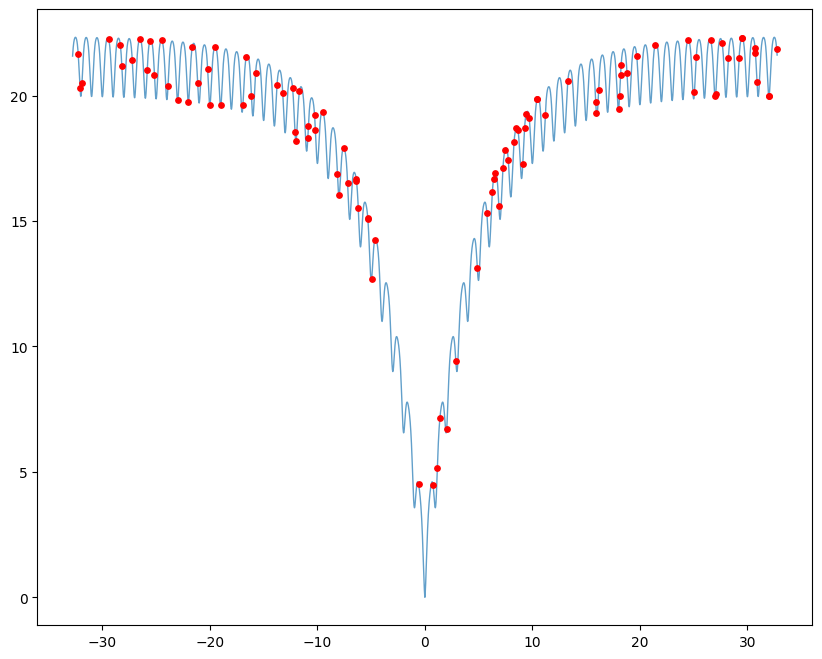

In [14]:
fig = plt.figure(figsize=(10,8))
plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


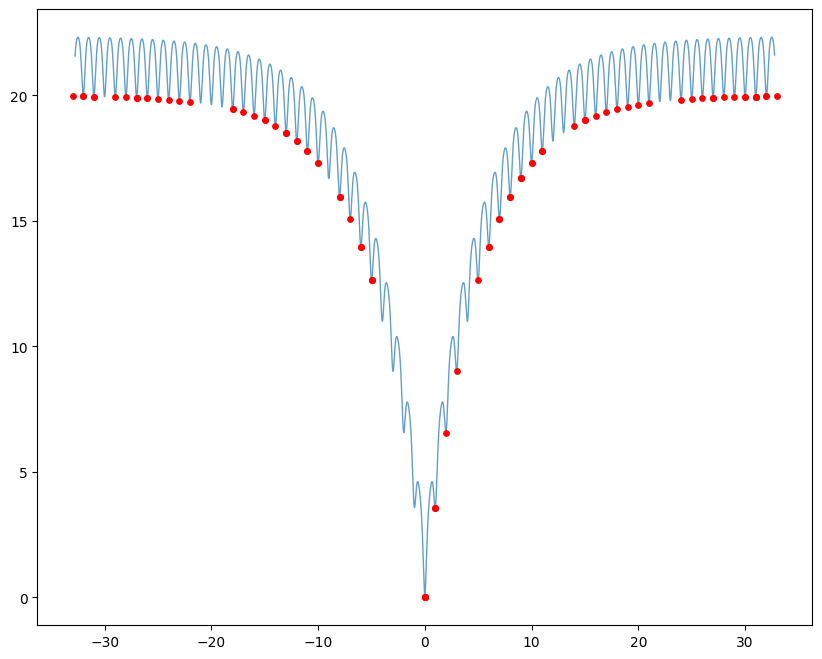

In [15]:
fig = plt.figure(figsize=(10,8))
# plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


## Fit a neural network

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)

In [18]:
hidden_dim = 16

model = nn.Sequential(
    nn.Linear(dimension, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1)
)

In [19]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [20]:
num_epochs = 10000

model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1168.12it/s]


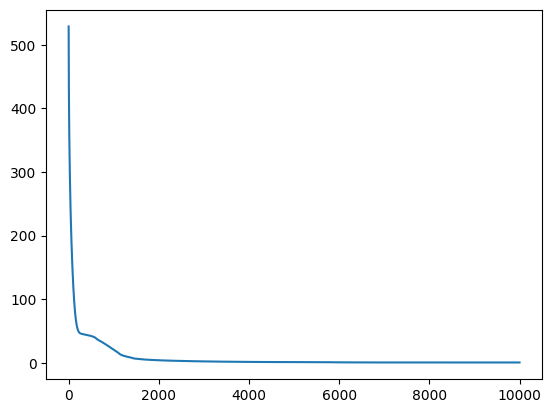

In [21]:
plt.plot(loss_record)

In [22]:
loss_record[-1]

0.7538480162620544

In [23]:
xs

array([-32.768, -32.758, -32.748, ...,  32.742,  32.752,  32.762])

In [24]:
with torch.no_grad():
    fitted_ys = model(torch.FloatTensor(np.expand_dims(xs, axis=1)).to(device)).detach().cpu().squeeze().numpy()

In [25]:
abs(ys - fitted_ys)

array([0.45149422, 0.38161469, 0.31562424, ..., 0.08309746, 0.14551735,
       0.21184731])

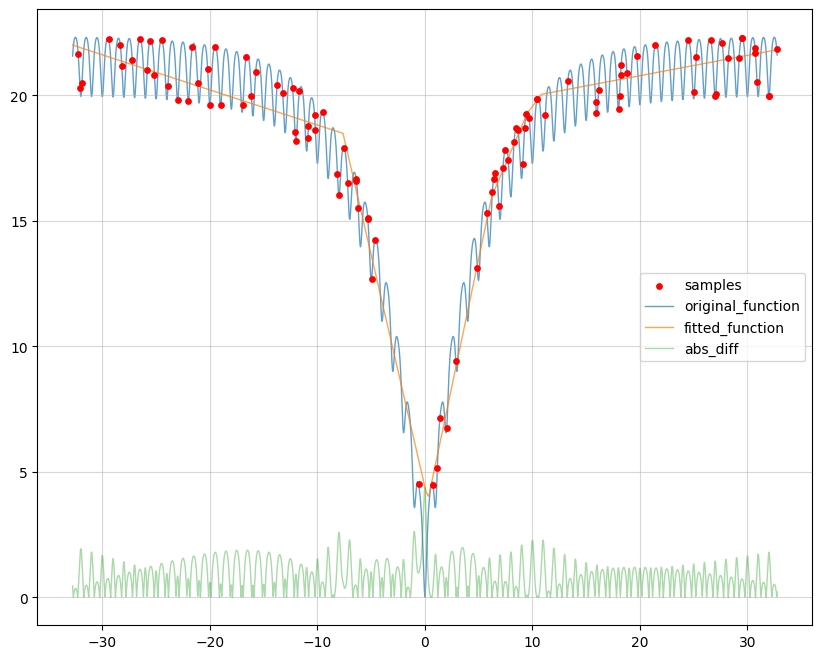

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(xs_train[:, 0], ys_train[:, 0], s=15, c='red', zorder=10, label="samples")
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

ax.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7, label="original_function")
ax.plot(xs, fitted_ys, linewidth=1, alpha=0.7, label="fitted_function")

# y_diff_squared = (ys - fitted_ys) ** 2
# ax.plot(xs, y_diff_squared, linewidth=1, alpha=0.4, label="squared_diff")

y_diff_abs = abs(ys - fitted_ys)
ax.plot(xs, y_diff_abs, linewidth=1, alpha=0.4, label="abs_diff")

ax.legend()

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

## Convert the neural network to ibex expression (through sympy) 

In [27]:
layer_idx = 2
layer = model[layer_idx]

In [28]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [29]:
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [30]:
inter_vars

(x[2][0],
 x[2][1],
 x[2][2],
 x[2][3],
 x[2][4],
 x[2][5],
 x[2][6],
 x[2][7],
 x[2][8],
 x[2][9],
 x[2][10],
 x[2][11],
 x[2][12],
 x[2][13],
 x[2][14],
 x[2][15])

In [31]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [32]:
W = weight.detach().cpu().numpy()

In [33]:
b = bias.detach().cpu().numpy()
b

array([-0.5920283], dtype=float32)

In [34]:
expression = (W @ X).squeeze(axis=1) + b
expression = expression.item()

In [35]:
layer_idx = 1
layer = model[layer_idx]
layer

ReLU()

In [36]:
prev_inter_vars = inter_vars
width = len(inter_vars)
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [37]:
inter_vars[0]

x[1][0]

In [38]:
replace_dict = {}
for curr_var, prev_var in zip(inter_vars, prev_inter_vars):
    replace_dict[prev_var] = Max(curr_var, 0)

In [39]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [40]:
expression

1.0933700799942*Max(0, x[1][0]) + 0.358826845884323*Max(0, x[1][10]) + 0.562004864215851*Max(0, x[1][11]) + 0.858177721500397*Max(0, x[1][12]) + 0.645220041275024*Max(0, x[1][13]) + 0.899636745452881*Max(0, x[1][14]) + 0.519101083278656*Max(0, x[1][15]) + 0.720349311828613*Max(0, x[1][1]) - 0.0761731863021851*Max(0, x[1][2]) - 1.9878340959549*Max(0, x[1][3]) + 0.861736118793488*Max(0, x[1][4]) - 2.17978596687317*Max(0, x[1][5]) - 2.06734085083008*Max(0, x[1][6]) + 0.866396367549896*Max(0, x[1][7]) + 0.785223424434662*Max(0, x[1][8]) - 1.57695317268372*Max(0, x[1][9]) - 0.592028319835663

In [41]:
layer_idx = 0
layer = model[layer_idx]
layer

Linear(in_features=1, out_features=16, bias=True)

In [42]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [43]:
prev_inter_vars = inter_vars
inter_vars = symbols(', '.join(['x[{}]'.format(i) for i in range(width)]))
if isinstance(inter_vars, sympy.Symbol):
    inter_vars = [inter_vars]

In [44]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [45]:
W = weight.detach().cpu().numpy()

In [46]:
b = bias.detach().cpu().numpy()
b

array([ 1.8778238 ,  1.4689794 , -0.8120363 , -2.7309587 ,  0.06302264,
       -5.9820867 , -3.1030977 ,  0.29420918, -0.3691355 , -2.5594766 ,
        0.01519685,  0.8113921 ,  1.1738629 , -0.32458097, -0.21616901,
        0.17502587], dtype=float32)

In [47]:
mat_res = (W @ X).squeeze(axis=1) + b

In [48]:
replace_dict = {}
for curr_expr, prev_var in zip(mat_res, prev_inter_vars):
    replace_dict[prev_var] = curr_expr
replace_dict

{x[1][0]: 0.0577150397002697*x[0] + 1.87782382965088,
 x[1][1]: 0.0444902218878269*x[0] + 1.4689793586731,
 x[1][2]: -0.0251407120376825*x[0] - 0.812036275863647,
 x[1][3]: 0.252230018377304*x[0] - 2.73095870018005,
 x[1][4]: 0.0630226358771324 - 0.656064033508301*x[0],
 x[1][5]: -0.785684049129486*x[0] - 5.98208665847778,
 x[1][6]: 0.500288009643555*x[0] - 3.10309767723083,
 x[1][7]: 0.294209182262421 - 0.925796329975128*x[0],
 x[1][8]: 1.01466274261475*x[0] - 0.369135499000549,
 x[1][9]: 0.269831091165543*x[0] - 2.55947661399841,
 x[1][10]: 0.0151968458667397 - 0.592987537384033*x[0],
 x[1][11]: 0.0236415714025497*x[0] + 0.81139212846756,
 x[1][12]: 0.0356105752289295*x[0] + 1.17386293411255,
 x[1][13]: 0.797466337680817*x[0] - 0.3245809674263,
 x[1][14]: 0.657944083213806*x[0] - 0.216169014573097,
 x[1][15]: 0.1750258654356 - 0.79205846786499*x[0]}

In [49]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [50]:
str(expression)

'0.358826845884323*Max(0, 0.0151968458667397 - 0.592987537384033*x[0]) + 0.861736118793488*Max(0, 0.0630226358771324 - 0.656064033508301*x[0]) + 0.519101083278656*Max(0, 0.1750258654356 - 0.79205846786499*x[0]) + 0.866396367549896*Max(0, 0.294209182262421 - 0.925796329975128*x[0]) - 2.17978596687317*Max(0, -0.785684049129486*x[0] - 5.98208665847778) - 0.0761731863021851*Max(0, -0.0251407120376825*x[0] - 0.812036275863647) + 0.562004864215851*Max(0, 0.0236415714025497*x[0] + 0.81139212846756) + 0.858177721500397*Max(0, 0.0356105752289295*x[0] + 1.17386293411255) + 0.720349311828613*Max(0, 0.0444902218878269*x[0] + 1.4689793586731) + 1.0933700799942*Max(0, 0.0577150397002697*x[0] + 1.87782382965088) - 1.9878340959549*Max(0, 0.252230018377304*x[0] - 2.73095870018005) - 1.57695317268372*Max(0, 0.269831091165543*x[0] - 2.55947661399841) - 2.06734085083008*Max(0, 0.500288009643555*x[0] - 3.10309767723083) + 0.899636745452881*Max(0, 0.657944083213806*x[0] - 0.216169014573097) + 0.645220041275

In [51]:
variables, func_expr = func.expression()

In [52]:
func_expr

' (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )'

### (Finally..) prune the box

In [53]:
expr_nn = str(expression).replace("Max", "max")

In [54]:
expr_nn

'0.358826845884323*max(0, 0.0151968458667397 - 0.592987537384033*x[0]) + 0.861736118793488*max(0, 0.0630226358771324 - 0.656064033508301*x[0]) + 0.519101083278656*max(0, 0.1750258654356 - 0.79205846786499*x[0]) + 0.866396367549896*max(0, 0.294209182262421 - 0.925796329975128*x[0]) - 2.17978596687317*max(0, -0.785684049129486*x[0] - 5.98208665847778) - 0.0761731863021851*max(0, -0.0251407120376825*x[0] - 0.812036275863647) + 0.562004864215851*max(0, 0.0236415714025497*x[0] + 0.81139212846756) + 0.858177721500397*max(0, 0.0356105752289295*x[0] + 1.17386293411255) + 0.720349311828613*max(0, 0.0444902218878269*x[0] + 1.4689793586731) + 1.0933700799942*max(0, 0.0577150397002697*x[0] + 1.87782382965088) - 1.9878340959549*max(0, 0.252230018377304*x[0] - 2.73095870018005) - 1.57695317268372*max(0, 0.269831091165543*x[0] - 2.55947661399841) - 2.06734085083008*max(0, 0.500288009643555*x[0] - 3.10309767723083) + 0.899636745452881*max(0, 0.657944083213806*x[0] - 0.216169014573097) + 0.645220041275

In [55]:
variables

['x[1]']

In [56]:
def expression_squared_diff(expr1, expr2):
    return "(({}) - ({})) ^ 2".format(expr1, expr2)

In [57]:
def expression_absolute_diff(expr1, expr2):
    return "abs(({}) - ({}))".format(expr1, expr2)

In [58]:
def expression_add_const(expr, const):
    return "({}) + ({})".format(expr, const)

In [59]:
ibex_expression = expression_squared_diff(func_expr, expr_nn)

In [60]:
ibex_expression = expression_absolute_diff(func_expr, expr_nn)

In [61]:
ibex_expression = expression_add_const(ibex_expression, -00)

In [62]:
ibex_expression

'(abs(( (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )) - (0.358826845884323*max(0, 0.0151968458667397 - 0.592987537384033*x[0]) + 0.861736118793488*max(0, 0.0630226358771324 - 0.656064033508301*x[0]) + 0.519101083278656*max(0, 0.1750258654356 - 0.79205846786499*x[0]) + 0.866396367549896*max(0, 0.294209182262421 - 0.925796329975128*x[0]) - 2.17978596687317*max(0, -0.785684049129486*x[0] - 5.98208665847778) - 0.0761731863021851*max(0, -0.0251407120376825*x[0] - 0.812036275863647) + 0.562004864215851*max(0, 0.0236415714025497*x[0] + 0.81139212846756) + 0.858177721500397*max(0, 0.0356105752289295*x[0] + 1.17386293411255) + 0.720349311828613*max(0, 0.0444902218878269*x[0] + 1.4689793586731) + 1.0933700799942*max(0, 0.0577150397002697*x[0] + 1.87782382965088) - 1.9878340959549*max(0, 0.252230018377304*x[0] - 2.73095870018005) - 1.57695317268372*max(0, 0.269831091165543*x[0] - 2.55947661399841) - 2.06734085083008*max(0

In [63]:
f = Function(*variables, ibex_expression)
X_in = IntervalVector(Interval(-10, 10))

In [64]:
ctc = CtcFwdBwd(f, GEQ)  # root is when f = 0
ctc.contract(X_in)

In [65]:
X_in

([-10, 10])

## Convert the neural network to dReal

In [66]:
import dreal

In [67]:
initial_variables = [dreal.Variable('x[{}]'.format(i)) for i in range(dimension)]

In [68]:
curr_vars = initial_variables
formulas_by_layer = []
vars_by_layer = [initial_variables]

for layer_idx, layer in enumerate(model):
    prev_vars = curr_vars
    if isinstance(layer, nn.Linear):
        W = layer.weight.detach().cpu().numpy()
        b = np.expand_dims(layer.bias.detach().cpu().numpy(), axis=1)
        X = np.expand_dims(prev_vars, axis=1)
        
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(W.shape[0])]
        vars_by_layer.append(curr_vars)
        expressions = (W @ X + b)[:, 0]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        
    elif isinstance(layer, nn.ReLU):
        layer_width = len(prev_vars)
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(layer_width)]
        vars_by_layer.append(curr_vars)
        
        expressions = [dreal.Max(0, prev_var) for prev_var in prev_vars]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        

In [69]:
all_formulas_nn = [formula for formulas in formulas_by_layer for formula in formulas]

In [70]:
all_formulas_nn

[<Formula "(x[1][0] == (1.877823829650879 + 0.0577150397002697 * x[0]))">,
 <Formula "(x[1][1] == (1.4689793586730958 + 0.04449022188782692 * x[0]))">,
 <Formula "(x[1][2] == (-0.81203627586364746 - 0.025140712037682534 * x[0]))">,
 <Formula "(x[1][3] == (-2.7309587001800537 + 0.25223001837730408 * x[0]))">,
 <Formula "(x[1][4] == (0.063022635877132416 - 0.65606403350830079 * x[0]))">,
 <Formula "(x[1][5] == (-5.9820866584777832 - 0.78568404912948609 * x[0]))">,
 <Formula "(x[1][6] == (-3.1030976772308349 + 0.50028800964355469 * x[0]))">,
 <Formula "(x[1][7] == (0.29420918226242066 - 0.92579632997512818 * x[0]))">,
 <Formula "(x[1][8] == (-0.36913549900054931 + 1.0146627426147461 * x[0]))">,
 <Formula "(x[1][9] == (-2.559476613998413 + 0.26983109116554261 * x[0]))">,
 <Formula "(x[1][10] == (0.01519684586673975 - 0.59298753738403321 * x[0]))">,
 <Formula "(x[1][11] == (0.81139212846755982 + 0.023641571402549744 * x[0]))">,
 <Formula "(x[1][12] == (1.1738629341125489 + 0.035610575228929

In [71]:
nn_value = vars_by_layer[-1][0]

## Convert Ackley to dReal

In [72]:
input_variables = initial_variables
a = 20
b = 0.2
c = 2 * np.pi

In [73]:
ackley_constraints = []

In [74]:
# Term 1

In [75]:
squared_summation = 0
for var in input_variables:
    squared_summation += var ** 2

In [76]:
var_ss = dreal.Variable("var_squared_summation")
ackley_constraints.append(var_ss == squared_summation)

In [77]:
var_sqrt = dreal.Variable("var_sqrt")
ackley_constraints.append(var_sqrt == (1 / dimension * var_ss) ** 0.5)

In [78]:
var_exp_1 = dreal.Variable("var_exp_1")
ackley_constraints.append(var_exp_1 == dreal.exp(-b * var_sqrt))

In [79]:
term_1 = -a * var_exp_1

In [80]:
# Term 2

In [81]:
cos_summation = 0
for var in input_variables:
    cos_summation += dreal.cos(c * var)

In [82]:
exp_2 = dreal.exp(1 / dimension * cos_summation)
term_2 = -exp_2

In [83]:
ackley_value = dreal.Variable("ackley_value")

In [84]:
ackley_constraints.append(ackley_value == term_1 + term_2 + a + np.exp(1))

In [85]:
ackley_constraints

[<Formula "(var_squared_summation == pow(x[0], 2))">,
 <Formula "(var_sqrt == pow(var_squared_summation, 0.5))">,
 <Formula "(var_exp_1 == exp((-0.20000000000000001 * var_sqrt)))">,
 <Formula "(ackley_value == (22.718281828459045 - 20 * var_exp_1 - exp(cos((6.2831853071795863 * x[0])))))">]

## Input constraints

In [86]:
func.get_default_domain()

array([[-32.768,  32.768]])

In [87]:
input_constraints = []
for dim in range(dimension):
    input_constraints.append(input_variables[dim] >= func.get_default_domain()[dim][0])
    input_constraints.append(input_variables[dim] <= func.get_default_domain()[dim][1])

## Output constraints

In [91]:
d = 4
output_constraints = []
output_constraints.append(dreal.Or(ackley_value - nn_value <= -d, ackley_value - nn_value >= d))

In [92]:
all_constraints = all_formulas_nn + ackley_constraints + input_constraints + output_constraints

In [93]:
dreal.CheckSatisfiability(dreal.And(*all_constraints), 0.001)

<Box "x[0] : [-0.05105316123401131, -0.050983728138624756]
x[1][0] : [1.8748772944218706, 1.874881327467614]
x[1][1] : [1.4667079922005147, 1.4667111011146026]
x[1][2] : [-0.81075451983534196, -0.81075276303776899]
x[1][3] : [-2.7438358399831583, -2.7438182145044751]
x[1][4] : [0.096470933946150348, 0.096516778777433407]
x[1][5] : [-5.9420299065128503, -5.9419750040173084]
x[1][6] : [-3.1286389616641576, -3.1286040022421746]
x[1][7] : [0.34140931824704196, 0.34147401159156699]
x[1][8] : [-0.42093723962488066, -0.42086633642051562]
x[1][9] : [-2.5732523442089436, -2.5732334887920669]
x[1][10] : [0.045429297104112914, 0.045470734238623932]
x[1][11] : [0.81018515151027982, 0.81018680355001516]
x[1][12] : [1.1720449016727861, 1.1720473900896631]
x[1][13] : [-0.36529414496421031, -0.36523841913892857]
x[1][14] : [-0.24975913995419224, -0.24971316374768184]
x[1][15] : [0.21540760619277389, 0.21546295412372419]
x[2][0] : [1.8748772944218706, 1.874881327467614]
x[2][1] : [1.4667079922005147, 1